# Fine-tuning ResNET50 (pretrained on ImageNET) on CIFAR10

Here, we present the process of fine-tuning the ResNET50 network (from [keras.applications](https://keras.io/applications/)).

We use Resnet50 from [keras.applications](https://keras.io/applications/)), which is already pretrained on ImageNET database. Next we add some additional layers in order to train the network on CIFAR10 dataset.

We used the [keras](https://keras.io/) python deep learning library.
Namely, we follow [keras.applications](https://keras.io/applications/#usage-examples-for-image-classification-models) tutorial.

One can try to fine-tune all of the following pretrained networks (from [keras.applications](https://keras.io/applications/)):
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* MobileNet

All of them can be initialized to be already pretrained on ImageNET dataset.
Here is the example to load the Inception_v3 CNN with keras
```python
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(include_top=False, weights='imagenet', \
                    input_tensor=None, input_shape=None, pooling=None, classes=1000)
```
The most important for **transfer learning** is to give the paramater
```python
include_top=False
```

since it builds the CNN model without the last (top) layer which is responsible to classify ImageNET categorized to 1000 classes.

In [1]:
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = 1; # int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
# hardcoded selection of InceptionV3 network
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Selected network:  resnet50


In [2]:
import time
import myutils
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras import backend as K

Using TensorFlow backend.


# Load CIFAR10 data
Here we use [keras.datasets](https://keras.io/datasets/) which is pretty similar to our <tt>myutils.load_CIFAR10_dataset()</tt> procedure.

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


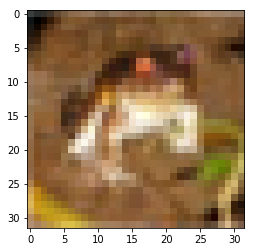

In [3]:
n_classes = 10
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

# Create model

In [4]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    base_model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return base_model, model

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    base_model = ResNet50(input_tensor=tf_input, include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return base_model, model

# TODO: build all the rest :-)
def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

# Data generator for tensorflow

The feature extraction can process the batches of data. It is common in feeding neural networks in tensorflow.

In [5]:
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize_images(batch_of_images_placeholder, (input_shape[:2]), method=0)

In [6]:
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet50     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

# Create model

In [7]:
sess = tf.InteractiveSession()

In [8]:
K.set_session(sess)
K.set_learning_phase(1)  # 0 - test,  1 - train

In [9]:
base_model, model = create_model()

In [10]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv1
2 bn_conv1
3 activation_1
4 max_pooling2d_1
5 res2a_branch2a
6 bn2a_branch2a
7 activation_2
8 res2a_branch2b
9 bn2a_branch2b
10 activation_3
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_1
16 activation_4
17 res2b_branch2a
18 bn2b_branch2a
19 activation_5
20 res2b_branch2b
21 bn2b_branch2b
22 activation_6
23 res2b_branch2c
24 bn2b_branch2c
25 add_2
26 activation_7
27 res2c_branch2a
28 bn2c_branch2a
29 activation_8
30 res2c_branch2b
31 bn2c_branch2b
32 activation_9
33 res2c_branch2c
34 bn2c_branch2c
35 add_3
36 activation_10
37 res3a_branch2a
38 bn3a_branch2a
39 activation_11
40 res3a_branch2b
41 bn3a_branch2b
42 activation_12
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_4
48 activation_13
49 res3b_branch2a
50 bn3b_branch2a
51 activation_14
52 res3b_branch2b
53 bn3b_branch2b
54 activation_15
55 res3b_branch2c
56 bn3b_branch2c
57 add_5
58 activation_16
59 res3c_branch2a
60 bn3c_branch2a
61 activation_17
62 res3c

In [11]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv1
2 bn_conv1
3 activation_1
4 max_pooling2d_1
5 res2a_branch2a
6 bn2a_branch2a
7 activation_2
8 res2a_branch2b
9 bn2a_branch2b
10 activation_3
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_1
16 activation_4
17 res2b_branch2a
18 bn2b_branch2a
19 activation_5
20 res2b_branch2b
21 bn2b_branch2b
22 activation_6
23 res2b_branch2c
24 bn2b_branch2c
25 add_2
26 activation_7
27 res2c_branch2a
28 bn2c_branch2a
29 activation_8
30 res2c_branch2b
31 bn2c_branch2b
32 activation_9
33 res2c_branch2c
34 bn2c_branch2c
35 add_3
36 activation_10
37 res3a_branch2a
38 bn3a_branch2a
39 activation_11
40 res3a_branch2b
41 bn3a_branch2b
42 activation_12
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_4
48 activation_13
49 res3b_branch2a
50 bn3b_branch2a
51 activation_14
52 res3b_branch2b
53 bn3b_branch2b
54 activation_15
55 res3b_branch2c
56 bn3b_branch2c
57 add_5
58 activation_16
59 res3c_branch2a
60 bn3c_branch2a
61 activation_17
62 res3c

In [12]:
#   first: train only the top layers (which were randomly initialized)
#   i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [13]:
y_train_one_hot = tf.one_hot( y_train, n_classes ).eval()

In [14]:
data_train_gen = data_generator(sess, X_train, y_train_one_hot )

In [15]:
# train the model on the new data for a "few" epochs
model.fit_generator(data_train_gen(), n_training/batch_size, verbose=1)

Epoch 1/1
3125/3125 [==============================] - 660s - loss: 0.7739   


## Validation

In [16]:
images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: X_test})
images = preprocess_input(images_resized)

In [17]:
result = model.predict(images, verbose=1)

10000/10000 [==============================] - 118s   


In [18]:
y_pred = [ np.argmax( result[i] ) for i in range(n_testing) ]

In [19]:
np.sum( y_pred == y_test ) / n_testing

0.82140000000000002

## Train again a little bit

In [20]:
# train the model on the new data for a "few" epochs
# model.fit_generator(data_train_gen(), n_training/batch_size, epochs=5, verbose=1)

## Validate again

In [30]:
result = model.predict(images, verbose=1)
y_pred = [ np.argmax( result[i] ) for i in range(n_testing) ]
np.sum( y_pred == y_test ) / n_testing

10000/10000 [==============================] - 110s   


0.81110000000000004

## Train more layers

In [31]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

In [21]:
for layer in model.layers[:16]:
   layer.trainable = False
for layer in model.layers[16:]:
   layer.trainable = True

In [22]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [23]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(data_train_gen(), n_training/batch_size, epochs=10, verbose=1)

Epoch 1/10
3125/3125 [==============================] - 1617s - loss: 0.2963  
Epoch 2/10
3125/3125 [==============================] - 1605s - loss: 0.0870  
Epoch 3/10
3125/3125 [==============================] - 1604s - loss: 0.0315  
Epoch 4/10
3125/3125 [==============================] - 1604s - loss: 0.0136  
Epoch 5/10
3125/3125 [==============================] - 1605s - loss: 0.0073  
Epoch 6/10
3125/3125 [==============================] - 1604s - loss: 0.0047  
Epoch 7/10
3125/3125 [==============================] - 1604s - loss: 0.0034  
Epoch 8/10
3125/3125 [==============================] - 1604s - loss: 0.0026  
Epoch 9/10
3125/3125 [==============================] - 1605s - loss: 0.0021  
Epoch 10/10
3125/3125 [==============================] - 1604s - loss: 0.0017  


In [24]:
# model.fit_generator(data_train_gen(), n_training/batch_size, epochs=3, verbose=1)

## Validate tuned network

In [25]:
result = model.predict(images, verbose=1)
y_pred = [ np.argmax( result[i] ) for i in range(n_testing) ]
np.sum( y_pred == y_test ) / n_testing

10000/10000 [==============================] - 109s   


0.92969999999999997

So we obtained ***92.97%*** on testing dataset

# Feature extraction

In [26]:
from keras.models import load_model
base_model.save('model/{network}-tuned.h5'.format(network=selected_network))

In [27]:
from keras.models import load_model
model.save('model/{network}-full-tuned.h5'.format(network=selected_network))

In [28]:
# output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(base_model.output)
model_tuned = base_model # Model(base_model.input, output_pooled)

In [29]:
def Xdata_generator(sess,data):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield batch_of_images__preprocessed
    return generator

In [30]:
Xdata_train_gen = Xdata_generator(sess, X_train)

In [31]:
ftrs_training = model_tuned.predict_generator(Xdata_train_gen(), n_training/batch_size, verbose=1)

3125/3125 [==============================] - 561s   


In [32]:
Xdata_test_gen = Xdata_generator(sess, X_test)

In [33]:
ftrs_testing = model_tuned.predict_generator(Xdata_test_gen(), n_testing/batch_size, verbose=1)

625/625 [==============================] - 112s   


In [34]:
sess.close()

In [35]:
ftrs_training.shape

(50000, 1, 1, 2048)

In [36]:
ftrs_testing.shape

(10000, 1, 1, 2048)

In [37]:
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

np.savez_compressed("features/CIFAR10_{}-tuned-keras_features.npz".format(selected_network), \
                    features_training=features_training, \
                    features_testing=features_testing,   \
                    labels_training=y_train,             \
                    labels_testing=y_test)

In [38]:
features_training.shape, features_testing.shape

((50000, 2048), (10000, 2048))

In [39]:
print('Ten first features of X_train[0] (see figure above, with the frog)')
features_training[0][0:10]

Ten first features of X_train[0] (see figure above, with the frog)


array([ 0.53709549,  0.03602256,  2.08684802,  0.00748194,  2.30611181,
        0.04273677,  0.20841408,  0.        ,  0.3882184 ,  0.03541341], dtype=float32)

Ten first features of X_train[0] (see figure above, with the frog)

    'incv3':
        array([ 0.29244769,  0.50564754,  0.21346107,  0.3144542 ,  0.33176085,
                0.3695876 ,  0.36724254,  0.24510881,  0.27722129,  0.14876673], dtype=float32)
    'vgg16'

# Feature visualization

Here we visualize the features extracted by the pretrained CNN network.

## Feature analysis (using PCA)

In [2]:
import numpy as np
import myutils

data = np.load("features/CIFAR10_{}-tuned-keras_features.npz".format(selected_network))

X_training = data['features_training']
y_training = data['labels_training']

X_testing = data['features_testing']
y_testing = data['labels_testing']

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 2048)


In [3]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_training)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
print(pca.explained_variance_ratio_)

[ 0.05888532  0.03576628]


In [5]:
X = pca.transform(X_training)

In [6]:
X.shape

(50000, 2)

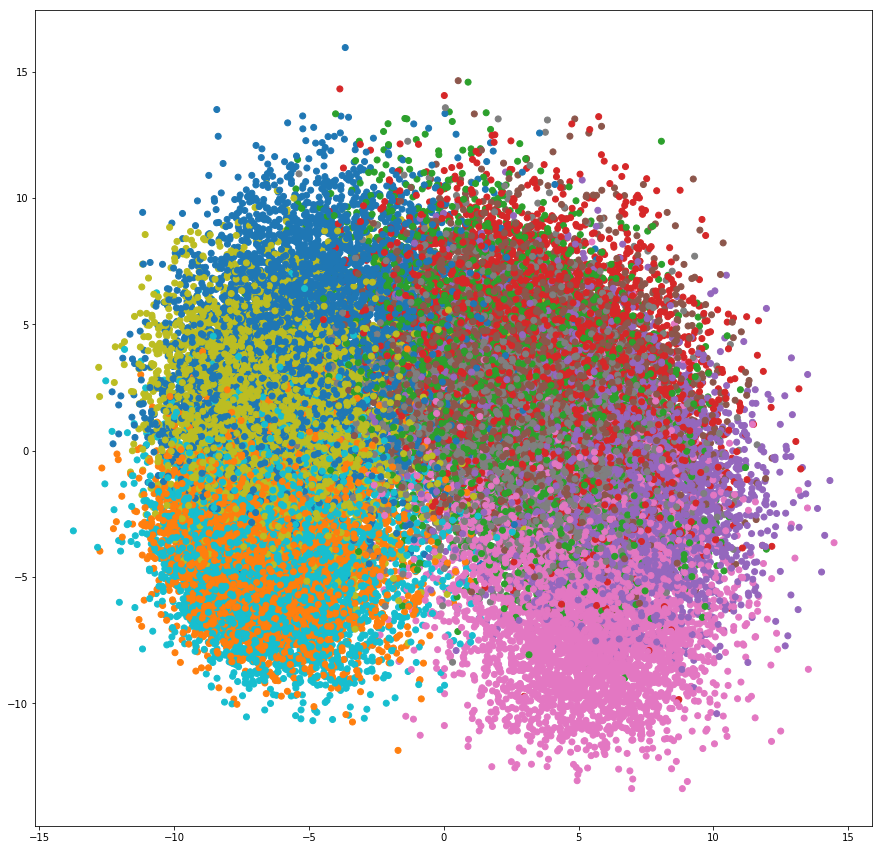

In [7]:
from matplotlib import pyplot as plt
plt.figure( figsize=(15,15) )
plt.scatter( X[:, 0], X[:, 1], c=y_training, cmap='tab10' )
# plt.colorbar()
plt.show()

## Feature analysis using t-SNE

In [16]:
from sklearn.manifold import TSNE
pca = decomposition.PCA(n_components=60)
X_training_reduced = pca.fit_transform(X_training)

Since t-SNE is quite complex, it is worth to compress the data. Let say that 55% is enough.

In [17]:
np.sum( pca.explained_variance_ratio_ )

0.55248189

In [18]:
tsne = TSNE(n_components=2)

In [19]:
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)

In [20]:
X_training_reduced_tsne.shape

(50000, 2)

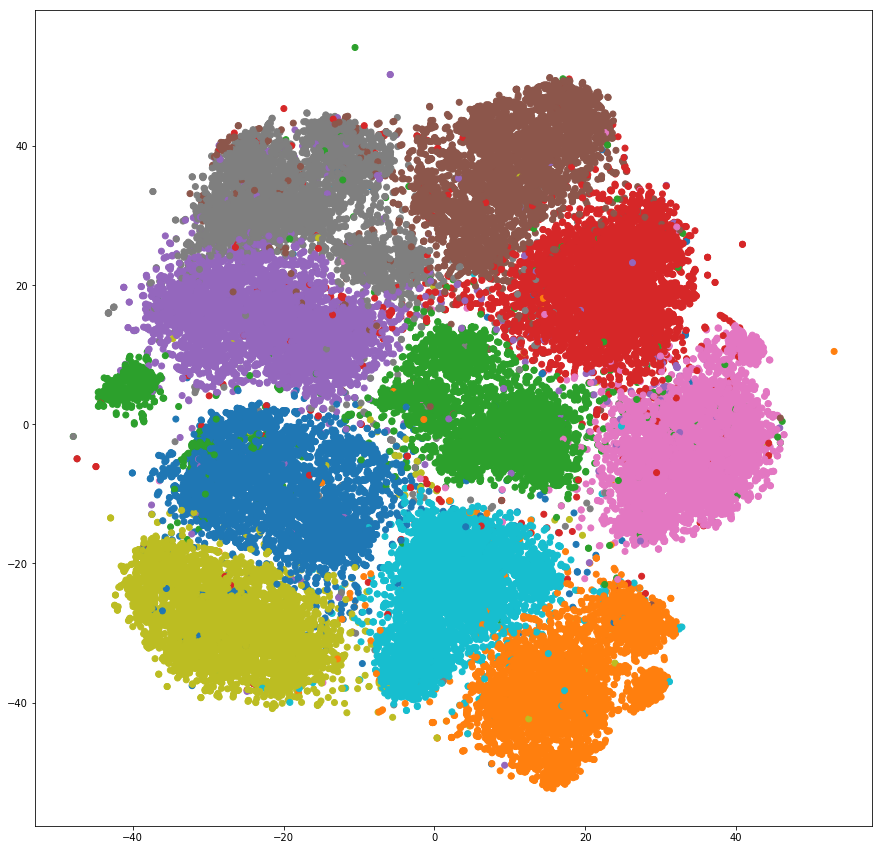

In [21]:
plt.figure( figsize=(15,15) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
plt.show()